In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math
from hodgkinhuxleyfunction import *

In [2]:
from pathlib import Path

In [3]:
functionalhhmodel_path = Path("C:\\Users\hudso\Documents\Research\Jeanne Lab")

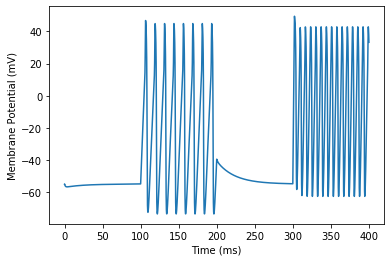

C:\Users\hudso\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


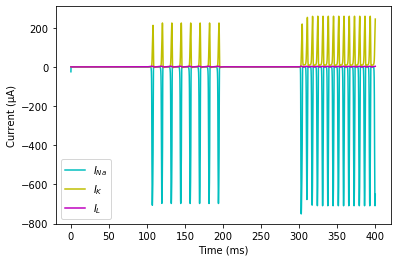

C:\Users\hudso\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


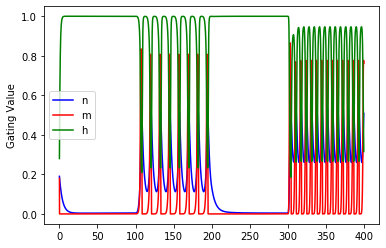

In [4]:
from functional_hh_model_copy import *

In [5]:
def multicompartmentmodel(Gsyn_dend,Gsyn_axon,r,cablelength,meanDendriteSurfAreaCM2,meanAxonSurfAreaCM2):
    # set simulation parameters
    numTimeSteps = 1000;
    dt = 0.0001; # (seconds)
    # timevec = dt:dt:dt*numTimeSteps
    
    # set parameters for connecting cable:
    r = 0.25 * (1/10000);    # (cm) radius of cable
    delta_x = 1 * (1/10000);   # (cm) length step of cable
    totalSegments = cablelength; # 102  each segment is isopotential. 1st segment is dendrite compartment, last segment is axon compartment

    # set basic electrical properties (in units normalized to surface area or length)
    rho_i = 350   # (ohm-cm) specific resistance of each segment
    g_L = 5.8e-5  # 1/(ohm-cm2) leak conductance through the membrane
    cm = 0.6*1e-6 # (uF/cm2) capacitance per unit area of membrane

    # set specific electrical properties (in "true" units)
    RA = (rho_i * delta_x /pi/r^2)
    R = (2*pi*r*delta_x*g_L) * ones(1,totalSegments)
    C = 2*pi*r*delta_x*cm * ones(1,totalSegments)
    
    # define size of axon and dendrite compartments
    meanDendriteSurfAreaCM2 = 1.2537e-5
    meanAxonSurfAreaCM2 = 5.3566e-6
    meanPrimaryAxonLengthCM = 0.0108
    meanPrimaryAxonDiameterCM = 5.1422e-5

    def R(totalSegments): g_L * meanAxonSurfAreaCM2
    def C(totalSegments): meanAxonSurfAreaCM2*cm
    # def R(1): g_L*meanDendriteSurfAreaCM2
    # def C(1): meanDendriteSurfAreaCM2*cm
    
    # define synaptic conductance waveform
    n_syn = 100 # number of synapses for a connection
    tau1 = 0.2/1000 # (seconds)
    tau2 = 1.1/1000 # (seconds)
    weight = 55e-12*n_syn # (picosiemens)
    factor = 1
    Gsyn_raw = (exp(-timevec/tau2) - exp(-timevec/tau1))
    Gsyn = (Gsyn_raw/max(Gsyn_raw)) * weight
    
    # initialize voltage vector
    realNcompartmentmodel = zeros(numTimeSteps,totalSegments)

    # run simulation
    for t in range (1, numTimeSteps-1): # time iterator
        # Backward Euler integration. (See Hines and Carnevale, NEURON book for details)
    
        # define system of equations
        A = zeros(totalSegments,totalSegments)
        # build A matrix
        for m in range (2, totalSegments-1):
            A_m = [-dt/C(m)/RA (1+dt/C(m)*(R(m)+(2/RA))) -dt/C(m)/RA]

        A_1 = [(1+dt/C(1)*(R(1)+(1/RA))) -dt/C(1)/RA]
        A_totalSegments = [-dt/C(totalSegments)/RA (1+dt/C(totalSegments)*(R(totalSegments)+(1/RA)))]

        b = V(t,t+1)
        # newValues = A\b# inv(A)*b; solve the system of equations for V(t+1) values
        # V(t+1,t+2) = newValues

        Isyn_dend = Gsyn_dend(t+1) * (0.045 - V(t+1,1) );
        Isyn_axon = Gsyn_axon(t+1) * (0.045 - V(t+1,totalSegments) );

        V_1 = V(t+1,1)+Isyn_dend(t+1)*dt/C(1);
        V_totalSegments = V(t+1,totalSegments)+Isyn_axon(t+1)*dt/C(totalSegments);

In [6]:
n_syn = [1] # number of synapses for a connection.
dt = 0.0001
numTimeSteps = 1000

tau1 = 0.2/1000 # (seconds)
tau2 = 1.1/1000 # (seconds)
factor = 1
# timevec = dt:dt:dt*numTimeSteps

timeoffset = [50, 100, 150]
timeoffset_vector = np.array(timeoffset)
Gsyn_raw = (exp(-timevec/tau2) - exp(-timevec/tau1))

# set parameters for a "median" LHN:
dendriteSurfAreaCM2 =  1.2537e-05 # (cm^2)
axonSurfAreaCM2 = 5.3566e-06 # (cm^2)
r = 0.25 * (1/10000)
cablelength = 102

V_axon = []
V_dend = []
for i in range (1, length(timeoffset)):
    Gsyn_raw_delay1 = [zeros(1,timeoffset(i)), Gsyn_raw(1,end-timeoffset(i))]
    Gsyn_raw_delay1_vector = np.array(Gsyn_raw_delay1)
    Gsyn_raw_delay = [zeros(1,100), Gsyn_raw(1,end-100)]
    Gsyn_raw_delay_vector = np.array(Gsyn_raw_delay)

    weight = 55e-12*n_syn # (picosiemens)
    Gsyn_dend = (Gsyn_raw_delay1/max(Gsyn_raw_delay1)) * weight
    Gsyn_axon = (Gsyn_raw_delay/max(Gsyn_raw_delay)) * weight
    V_all = realNcompartmentModel(Gsyn_dend*4, Gsyn_axon, r, cablelength,dendriteSurfAreaCM2,axonSurfAreaCM2)
    V_axon(:,i) = 1000*V_all(:,102) #102nd column
    V_dend(:,i) = 1000*V_all(:,1) #1st column
    # V_axonFirstStim=realNcompartmentModel(Gsyn_axon/20, Gsyn_dend/20)
    
for i in range (1, 3):
    subplot(2,3,i)
    plot(timevec,V_axon(:,i)) # ith column
    ylim([0 1.6])
    xlim([0 0.05])
    subplot(2,3,i+3)
    plot(timevec,V_dend(:,i)) #ith column
    ylim([0 1.6])
    xlim([0 0.05])

SyntaxError: invalid syntax (<ipython-input-6-e6635b8b90aa>, line 32)